# Sentence BERT clustering demo

This notebook will showcase a quick demo for how our clustering system works behind the scenes. A potential use case can then be seen in our web app demo.

In [1]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, GPT2LMHeadModel
from bertopic import BERTopic
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from bertopic.vectorizers import ClassTfidfTransformer

/home/rka/Documents/NLP_project/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch news dataset

The initial idea behind this project is to cluster notes based on their content, which could for example be useful in note-taking apps like Notion or Obsidian. Due to the lack of available datasets, this demo will use a news dataset instead, which we find to be similar enough to notes for this purpose (small to medium length, with texts about a variety of recognizable topics like science or sports).

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
idxs = [ i for i in range(len(newsgroups_train.data)) if len(newsgroups_train.data[i]) > 20 ]
newsgroups_train.data = [ newsgroups_train.data[i] for i in idxs ]
newsgroups_train.target = [ newsgroups_train.target[i] for i in idxs ]

In [3]:
docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))['data']

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topics()
topic_model.generate_topic_labels()

['-1_the_to_of',
 '0_team_game_he',
 '1_patients_msg_of',
 '2_key_chip_clipper',
 '3_hello_ites_hi',
 '4_card_monitor_video',
 '5_israel_israeli_arab',
 '6_image_jpeg_gif',
 '7_ram_ibm_motherboard',
 '8_fbi_koresh_batf',
 '9_amp_offer_condition',
 '10_space_moon_lunar',
 '11_car_cars_toyota',
 '12_ted_post_posts',
 '13_jesus_hell_god',
 '14_drive_drives_slave',
 '15_window_widget_application',
 '16_gun_guns_crime',
 '17_fpu_speed_mhz',
 '18_den_points_polygon',
 '19_bike_bikes_miles',
 '20_printer_ink_print',
 '21_tobacco_smokeless_health',
 '22_islam_quran_religion',
 '23_moral_morality_objective',
 '24_atheists_god_atheism',
 '25_oil_diesel_drain',
 '26_armenian_turkish_armenians',
 '27_dos_1st_art',
 '28_simms_simm_ram',
 '29_blacks_crimes_penalty',
 '30_games_joystick_game',
 '31_clinton_bush_administration',
 '32_modem_fax_modems',
 '33_windows_swap_memory',
 '34_scsi_ide_scsi2',
 '35_judas_bible_books',
 '36_weaver_trial_cooper',
 '37_orbit_km_mass',
 '38_radio_antenna_ham',
 '39

In [4]:
print("Train data size: ", len(newsgroups_train.data))

print("Average train data length: ", np.mean([len(x.split()) for x in newsgroups_train.data]))

print("Train data labels: ", newsgroups_train.target_names)
print("Number of train data labels: ", len(newsgroups_train.target_names))

print(f"Example:\n[{newsgroups_train.target_names[newsgroups_train.target[0]]}] ", newsgroups_train.data[0])

Train data size:  10955
Average train data length:  191.90652670013694
Train data labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of train data labels:  20
Example:
[rec.autos]  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car,

## Generate sentence embeddings

We use the [SentenceBERT](https://sbert.net/index.html) project implementation of a Sentence Transformer to generate sentence embeddings. We tested a variety of different models from their collection, which all seem to yield similar results. The embedding is a 384-dimensional vector for every article.

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(newsgroups_train.data, show_progress_bar=True)
train_embeddings.shape

Batches:  19%|█▊        | 64/343 [03:04<10:35,  2.28s/it]

## Cluster the embeddings

We then use a simple implementation of KMeans to cluster the embeddings together, which could be useful for grouping similar notes together. The number of clusters is set to 20, in this case, since we know the dataset had 20 categories. On our web demo we implemented a variable number of clusters, which acts as a different "zoom level" into the dataset.

In [252]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(train_embeddings)

## Create the graph using tSNE

We perform dimensionality reduction on the embeddings with t-SNE to be able to plot them.

In [241]:
tsne = TSNE(n_components=2, n_iter=1000, n_iter_without_progress=200, perplexity=35)
print(train_embeddings.shape)
tsne_embeddings = tsne.fit_transform(train_embeddings)

(10955, 384)


ValueError: cannot reshape array of size 1161123 into shape (10955,106)

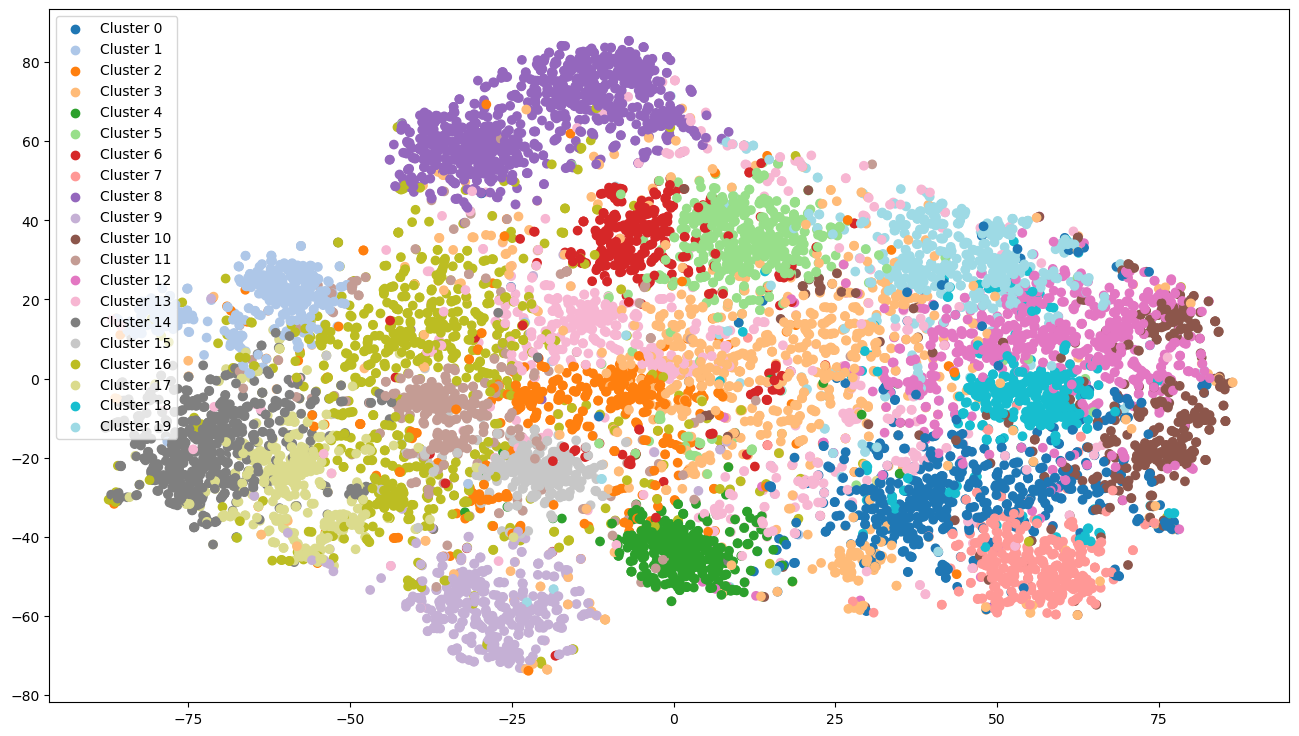

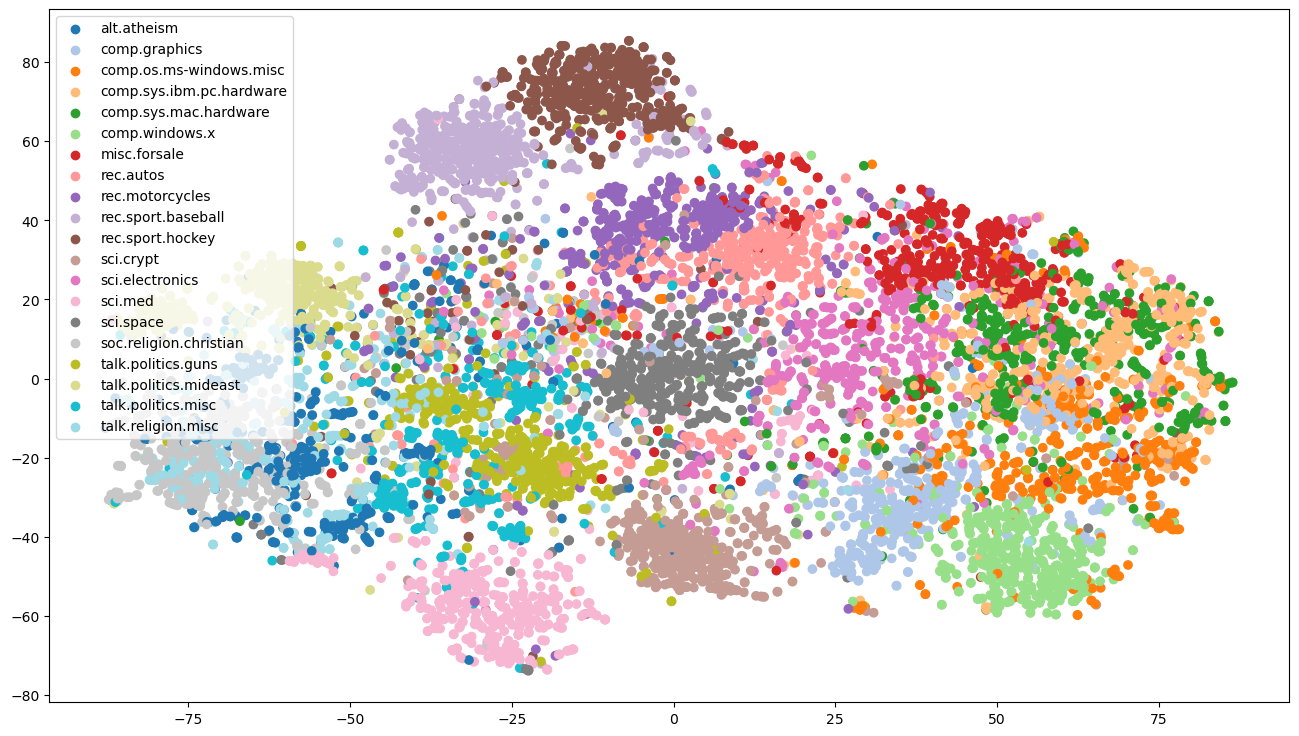

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()

We can see comparing the original labels (on the bottom) with the computed clusters (on the top) that the clustering algorithm did a pretty good job at grouping similar articles together, and finds clusters that are similar to the original dataset. This means that the embedding worked well enough to separate different articles and group similar ones together in the vector space.

## Cluster labelling

To generate topics that can act as labels for our clusters, we use Latent Dirichlet Allocation (LDA) on the original dataset. This is a common technique used in topic modelling, which we can use to generate a list of topics for each cluster. We then use the most common topic for each cluster as its label. A topic is a list of 5 words that somehow represent the cluster.

In [ ]:
X = np.empty(num_clusters, dtype=object)
for i in range(num_clusters):
    X[i] = '\n'.join([newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if kmeans.labels_[j] == i])

vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=0.2,
    max_features=100000,
    stop_words='english',
)
X = vectorizer.fit_transform(X).todense()

features = np.array(vectorizer.get_feature_names_out())
tfidf_sort = np.argsort(X)

n = 20
top_n = features[tfidf_sort][:,-n:]
top_n = [kw[::-1] for kw in top_n]

print(top_n)


In [239]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

X = np.empty(num_clusters, dtype=object)
for i in range(num_clusters):
    X[i] = '\n'.join([newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if kmeans.labels_[j] == i])

vectorizer = CountVectorizer(
    max_df=0.8,
    min_df=0.2,
    max_features=100000,
    stop_words="english",
    preprocessor=preprocess
)

ctfidf_model = ClassTfidfTransformer()

X = vectorizer.fit_transform(X)
X = ctfidf_model.fit_transform(X).todense()

features, tfidf_sort = np.array(vectorizer.get_feature_names_out()), np.argsort(X)

num_keywords = 20
top_n = features[tfidf_sort][:,-num_keywords:].tolist()
top_n = [kw[::-1] for kw in top_n]
keywords = {i: top_n[i] for i in range(len(top_n))}

print("Keywords of clusters are:\n")
for n in range(len(keywords)):
    print("Cluster %s: %s" % (n, keywords[n]))

Keywords of clusters are:

Cluster 0: ['jpeg', 'cx', 'c_', 'ftp', 'graphics', 'format', 'gif', 'dos', 'images', 'pc', 'mac', 'zip', 'unix', 'ck', 'shareware', 'user', 'tiff', 'hz', 'directory', 'pub']
Cluster 1: ['israel', 'turkish', 'jews', 'israeli', 'turkey', 'turks', 'armenia', 'killed', 'genocide', 'jewish', 'greek', 'soldiers', 'government', 'muslim', 'soviet', 'villages', 'apartment', 'peace', 'russian', 'women']
Cluster 2: ['government', 'launch', 'nasa', 'billion', 'tax', 'president', 'administration', 'russia', 'russian', 'water', 'moon', 'funds', 'clinton', 'senior', 'lunar', 'congress', 'satellite', 'shuttle', 'funding', 'budget']
Cluster 3: ['ax', 'max', 'bf', 'pl', 'di', 'wm', 'ei', 'um', 'sl', 'mu', 'gk', 'mq', 'mk', 'pu', 'bj', 'ml', 'mv', 'ff', 'wt', 'tl']
Cluster 4: ['encryption', 'clipper', 'keys', 'privacy', 'government', 'security', 'des', 'nsa', 'escrow', 'secure', 'algorithm', 'crypto', 'enforcement', 'encrypted', 'eff', 'rsa', 'cryptography', 'secret', 'agencies

## Obtaining a 1-word summary of the keywords
It does not work well for now, we could perhaps improve it by training a model on (doc, topic) pairs comming from the intial dataset.

In [240]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

query = f"A single word to define the topic given by the keywords [{', '.join(cluster_keywords[2])}] is: "
inputs = tokenizer(query, return_tensors='pt').input_ids
outputs = model.generate(inputs, max_new_tokens=10, do_sample=False)
label = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(label)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}: {labels[i]}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()

NameError: name 'tsne_embeddings' is not defined

<Figure size 1600x900 with 0 Axes>

We can now compare the generated topics (here represented as just the first word of the first topic, so a very poor summary) with the original labels. We can see that the topics are not perfect, but they are still pretty good. Expanding to use all topics generated for a cluster and somehow summarizing them would probably yield better results.